In [0]:
from fastai.collab import *
from fastai.tabular import *

In [18]:
!curl -s https://course.fast.ai/setup/colab | bash
#!curl https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [0]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [0]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
doc(collab_learner)

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,1.836745,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


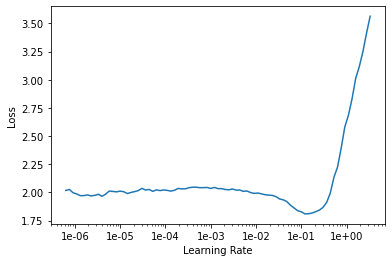

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.599536,0.926991,00:00
1,0.849036,0.676297,00:00
2,0.651652,0.670015,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
path=Config.data_path()/'ml-100k2'

In [21]:
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/ml-100k2')

In [0]:
#! unzip -q -n {path}/ml-100k.zip -d {path}

In [22]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [24]:
len(ratings)

100000

In [25]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [27]:
data.show_batch()

userId,title,target
128,Giant (1956),3.0
858,Donnie Brasco (1997),3.0
305,Clerks (1994),4.0
532,Four Weddings and a Funeral (1994),4.0
682,Mortal Kombat (1995),3.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


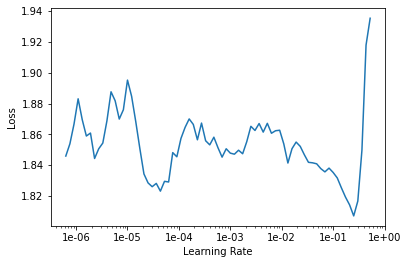

In [30]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [31]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.929413,0.944574,00:08
1,0.890744,0.888552,00:08
2,0.775318,0.835306,00:08
3,0.659049,0.815521,00:08
4,0.578379,0.814960,00:08


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [35]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [36]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [39]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3530),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3340),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2859), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2843), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2765), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2490), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2316), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2302), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2262), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2246), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2214), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2197), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.2177), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2171), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.21

In [40]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5993), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5737), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5669), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5468), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5152), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5150), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5148), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5070), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5036), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5031), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4963), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4898), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4885), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4657), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4654), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [41]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [42]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1357), 'Close Shave, A (1995)'),
 (tensor(1.1180), 'Chinatown (1974)'),
 (tensor(1.0765), 'Wrong Trousers, The (1993)'),
 (tensor(1.0608), 'Lawrence of Arabia (1962)'),
 (tensor(1.0196),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0057), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9904), 'Casablanca (1942)'),
 (tensor(0.9518), 'Ran (1985)'),
 (tensor(0.9195), 'Godfather, The (1972)'),
 (tensor(0.9193), 'North by Northwest (1959)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3976), 'Home Alone 3 (1997)'),
 (tensor(-1.2389), "McHale's Navy (1997)"),
 (tensor(-1.2175), 'Jungle2Jungle (1997)'),
 (tensor(-1.1808), 'Bio-Dome (1996)'),
 (tensor(-1.1009), 'Congo (1995)'),
 (tensor(-1.0883), 'Leave It to Beaver (1997)'),
 (tensor(-1.0462), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0432), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0218), 'Batman & Robin (1997)'),
 (tensor(-1.0062), 'Grease 2 (1982)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [47]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8687), 'Keys to Tulsa (1997)'),
 (tensor(0.8288), 'Trainspotting (1996)'),
 (tensor(0.8122), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8111), 'Showgirls (1995)'),
 (tensor(0.8095), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7843), 'Clockwork Orange, A (1971)'),
 (tensor(0.7747), 'Jude (1996)'),
 (tensor(0.7730), 'Brazil (1985)'),
 (tensor(0.7543), 'Dead Man (1995)'),
 (tensor(0.7476), 'Beavis and Butt-head Do America (1996)')]

In [48]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1564), 'Braveheart (1995)'),
 (tensor(-1.0856), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0622), 'Titanic (1997)'),
 (tensor(-0.9846), "It's a Wonderful Life (1946)"),
 (tensor(-0.8887), 'American President, The (1995)'),
 (tensor(-0.8749), 'Forrest Gump (1994)'),
 (tensor(-0.8543), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8533), 'Pretty Woman (1990)'),
 (tensor(-0.8455), 'Top Gun (1986)'),
 (tensor(-0.8185), 'Star Wars (1977)')]

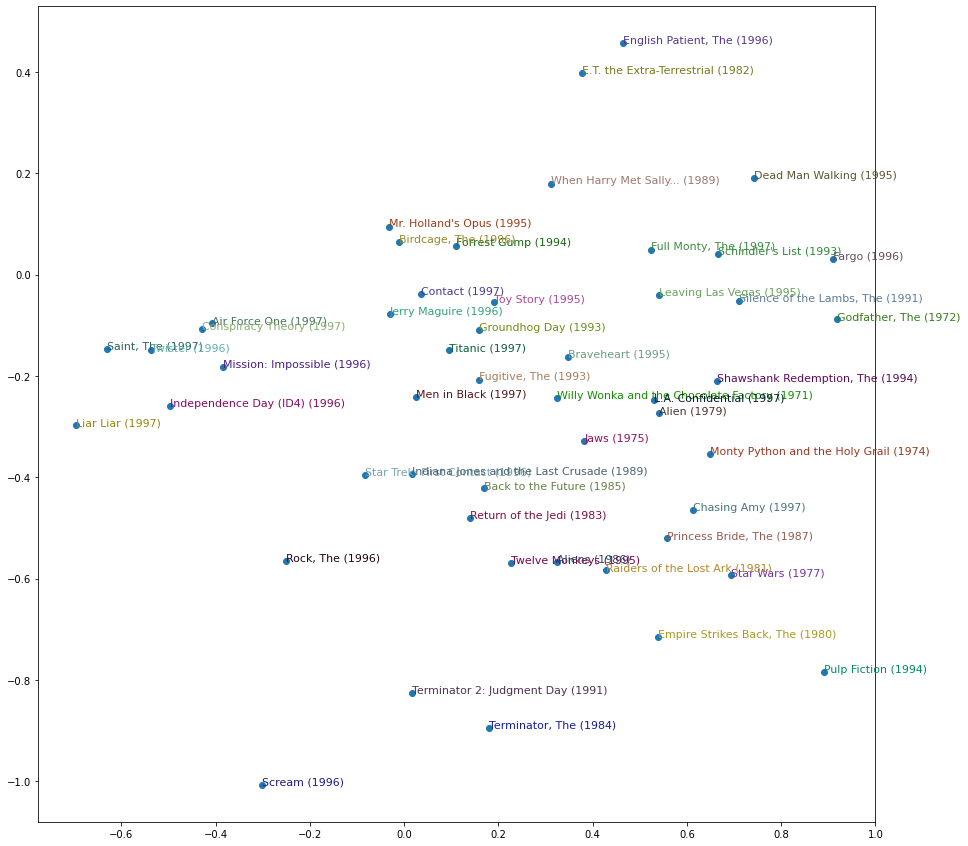

In [49]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()